# Emission Impact Analysis (Case: RTS)

In this analysis, we want to study the emissions Impact of virtual bids/offers in a grid

## Dependencies and Data Preparation

#### Packages and Diretory

In [1]:
#make sure it is in "GridAnalysis.jl" 
cd("/home/rafaela/Documents/PUC/LAMPS/github/GridAnalysis.jl")

In [2]:
pwd()

"/home/rafaela/Documents/PUC/LAMPS/github/GridAnalysis.jl"

In [3]:
using Pkg
Pkg.activate("./examples/RTS/emission_impact_analysis_RTS")

In [4]:
Pkg.instantiate()

In [5]:
using Logging 
Logging.disable_logging(Logging.Info) #script to disable info messages 
Logging.disable_logging(Logging.Warn) #script to disable warning messages

LogLevel(1001)

In [6]:
using Dates
using DataFrames
using GridAnalysis
using Gurobi
using PowerSystems
using PowerSimulations
using Test
using Measures
using Plots

const PSY = PowerSystems

PowerSystems

#### Getting the data

In [7]:
# set directory
rts_dir = download("https://github.com/GridMod/RTS-GMLC", "master", mktempdir())
# Or clone the directory and open as:
# for example: rts_dir = "/home/rafaela/Documents/PUC/LAMPS/github/RTS-GMLC"
rts_src_dir = joinpath(rts_dir, "RTS_Data", "SourceData")
rts_siip_dir = joinpath(rts_dir, "RTS_Data", "FormattedData", "SIIP");

#### Uploading Utils

Might not work if running lines manually 
(solution: edit to be the path for this examples directory for example: 'example_dir = "./examples/RTS/"')

In [8]:
example_dir = "./examples/RTS/"

include(joinpath(example_dir, "utils.jl")) # case utilities
include(joinpath(example_dir, "modify_RTS.jl")) # functions that modify the RTS problem

rts_modifier_function!

#### Data Prep and Build Market Simulator
define solvers for Unit Commitment (UC), Real Time (RT) and Economic Dispatch (ED)

In [9]:
solver_uc = optimizer_with_attributes(Gurobi.Optimizer)
solver_rt = optimizer_with_attributes(Gurobi.Optimizer)
solver_ed = optimizer_with_attributes(Gurobi.Optimizer)

MathOptInterface.OptimizerWithAttributes(Gurobi.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[])

## Define analysis to be done

In [22]:
Network = [DCPPowerModel]
Ramp = [true]
Minimal_generation = [true]
Reserve = [true]
Offer_Bus = ["Austen", "Bloch", "Chifa"]
bidding_period = [collect(1:24)]
Offer_Bus_mix = ["Austen", "Bloch", "Chifa"]
Load_Bus_mix = ["Aubrey", "Barkla", "Caesar"] # [wind, solar, wind]
directory_name = ["Net_DCPP_Load_Austen_Offer_Aubrey_period_1-24", "Net_DCPP_Load_Bloch_Offer_Barkla_period_1-24", "Net_DCPP_Load_Chifa_Offer_Caesar_period_1-24"]

3-element Vector{String}:
 "Net_DCPP_Load_Austen_Offer_Aubrey_period_1-24"
 "Net_DCPP_Load_Bloch_Offer_Barkla_period_1-24"
 "Net_DCPP_Load_Chifa_Offer_Ceasar_period_1-24"

#### Create a DataFrame where each line represents one analysis 

In [16]:
df = DataFrame(Network = [], 
               Ramp = [],
               Minimal_generation = [],
               Reserve = [],
               Offer_Bus = [],
               bidding_period = []) 

for a in Network 
    for b in Ramp 
        for c in Minimal_generation 
            for d in Reserve
                for e in Offer_Bus
                    for f in bidding_period
                        new_data = DataFrame(Network = [Dict("DA"=>a, "RT"=>a)], 
                        Ramp = [Dict("DA"=>b, "RT"=>b)],
                        Minimal_generation = [Dict("DA"=>c, "RT"=>c)],
                        Reserve = [d],
                        Offer_Bus = [e],
                        bidding_period = [f])
                        append!(df, new_data)
                    end
                end
            end
        end
    end
end
df[!,5]

3-element Vector{Any}:
 "Austen"
 "Bloch"
 "Chifa"

In [23]:
df_mix = DataFrame(Network = [], 
               Ramp = [],
               Minimal_generation = [],
               Reserve = [],
               Offer_Bus = [],
               Load_Bus = [],
               bidding_period = [],
               directory_name=[]) 

for (k,i) in enumerate(Offer_Bus)
    new_data_1 = DataFrame(Network = [Dict("DA"=>DCPPowerModel, "RT"=>DCPPowerModel)],
    Ramp = [Dict("DA"=>true, "RT"=>true)],
    Minimal_generation = [Dict("DA"=>false, "RT"=>false)],
    Reserve = [true],
    Offer_Bus = [i],
    Load_Bus = Load_Bus_mix[k],
    bidding_period = [collect(1:24)],
    directory_name = directory_name[k])
    append!(df_mix, new_data_1)
end

df_mix[!, 5:8]

,Offer_Bus,Load_Bus,bidding_period
,Any,Any,Any
1,Austen,Aubrey,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
2,Bloch,Barkla,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
3,Chifa,Caesar,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"


#### Define range quota and period to be analysed

In [24]:
range_quota = Float64.(collect(0:1:4))
range_quota_mix = Float64.(collect(0:1:4))
initial_time = Date("2020-09-01")
period_analysed = [5,16,19,20]
initial_bidding_time = DateTime("2020-09-01")
path = "results"

"results"

## Run & Load all the simulations

In [27]:
run_set_of_simulations(df, rts_src_dir, rts_siip_dir, example_dir, solver_uc, solver_ed, solver_rt,
    range_quota, initial_time, initial_bidding_time, path)

In [26]:
run_set_of_simulations_mix(df_mix, rts_src_dir, rts_siip_dir, example_dir, solver_uc, solver_ed, 
    solver_rt, range_quota_mix, range_quota_mix, initial_time, initial_bidding_time, path)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
  Step:                  1
  problem:               RT
  Simulation Timestamp:  2020-09-01T23:45:00


In [28]:
lines=[1,2,3]
period_analysed=[[5],[16],[19],[20]] 

4-element Vector{Vector{Int64}}:
 [5]
 [16]
 [19]
 [20]

### Generate graphics 

#### Generation stack virtual

In [30]:
graphic="plot_generation_stack_virtual"
plt_g=load_plot_set_of_simulations(
    df, 
    example_dir, 
    rts_src_dir,
    rts_siip_dir,
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
    true,
)

3×4×2 Array{Any, 3}:
[:, :, 1] =
 Plot{Plots.GRBackend() n=6}  …  Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}     Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}     Plot{Plots.GRBackend() n=6}

[:, :, 2] =
 Plot{Plots.GRBackend() n=5}  …  Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}     Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}     Plot{Plots.GRBackend() n=5}

#### Revenue curves (renewable plus virtual)

In [32]:
graphic="plot_revenue_curves_renewable_plus_virtual"
plt_rv=load_plot_set_of_simulations(
    df, 
    example_dir, 
    rts_src_dir,
    rts_siip_dir,
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
    true,
)

3-element Vector{Any}:
 Plot{Plots.GRBackend() n=9}
 Plot{Plots.GRBackend() n=9}
 Plot{Plots.GRBackend() n=9}

In [45]:
lines_mix=[1]

plt_mix, h_mix = load_plot_set_of_simulations_mix(
    df_mix, 
    example_dir, 
    rts_src_dir,
    rts_siip_dir,
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota_mix, 
    range_quota_mix,
    initial_time,
    lines_mix,
    initial_bidding_time,
    path,
)

LoadError: MethodError: no method matching get_bus(::Nothing)
[0mClosest candidates are:
[0m  get_bus([91m::RegulationDevice{InterruptibleLoad}[39m) at none:1
[0m  get_bus([91m::RenewableDispatch[39m) at /home/rafaela/.julia/packages/PowerSystems/DdZ5W/src/models/generated/RenewableDispatch.jl:105
[0m  get_bus([91m::RegulationDevice{RenewableDispatch}[39m) at none:1
[0m  ...

### Coal commitments: Can virtual bid/offers reduce coal commitments in DA and/or RT dispatch?

Generation - virtual offer on Austen

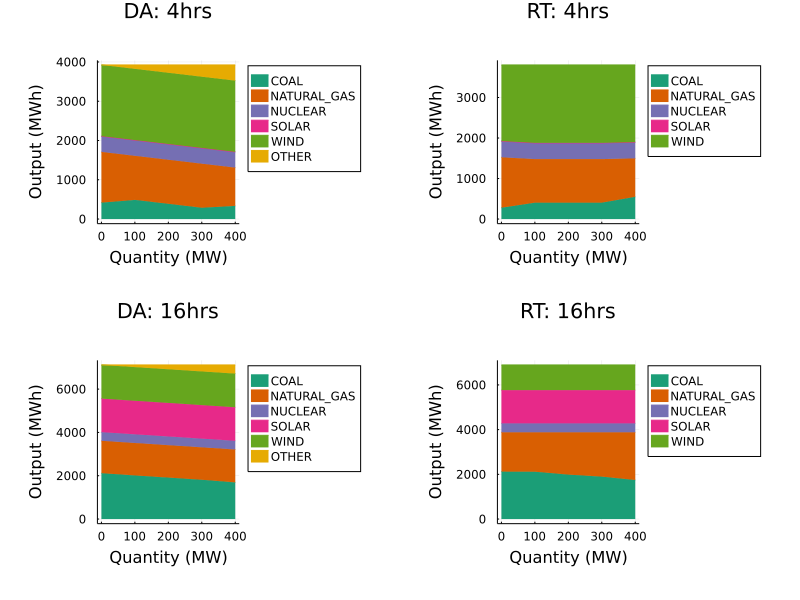

In [34]:
plot(plt_g[1,1,1], plt_g[1,1,2],plt_g[1,2,1], plt_g[1,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 16hrs" "RT: 16hrs"])

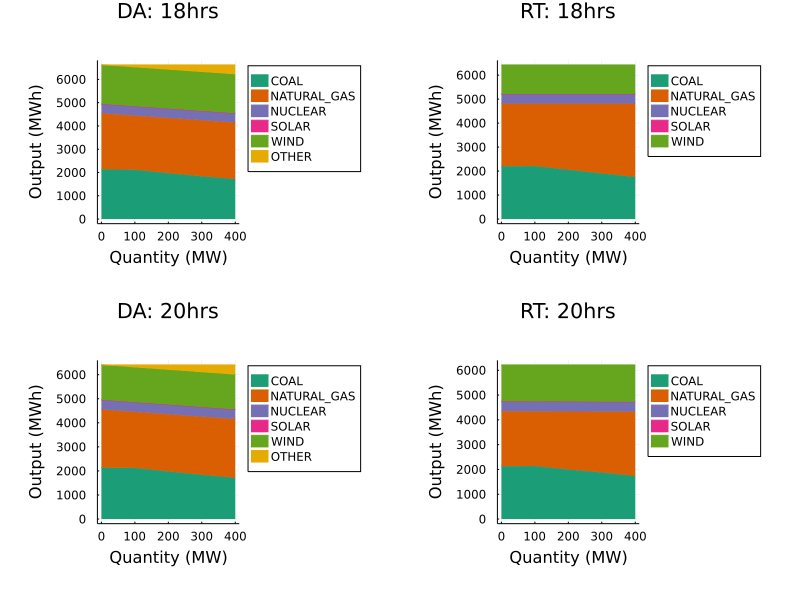

In [35]:
plot(plt_g[1,3,1], plt_g[1,3,2],plt_g[1,4,1], plt_g[1,4,2],layout=4,title=["DA: 18hrs" "RT: 18hrs" "DA: 20hrs" "RT: 20hrs"])

Economic viability

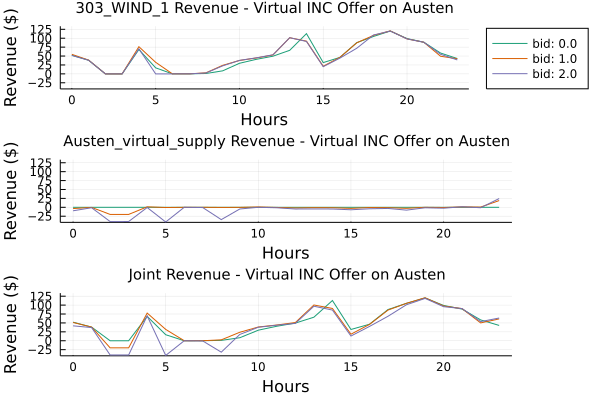

In [36]:
plt_rv[1]

Generation - virtual offer on Bloch

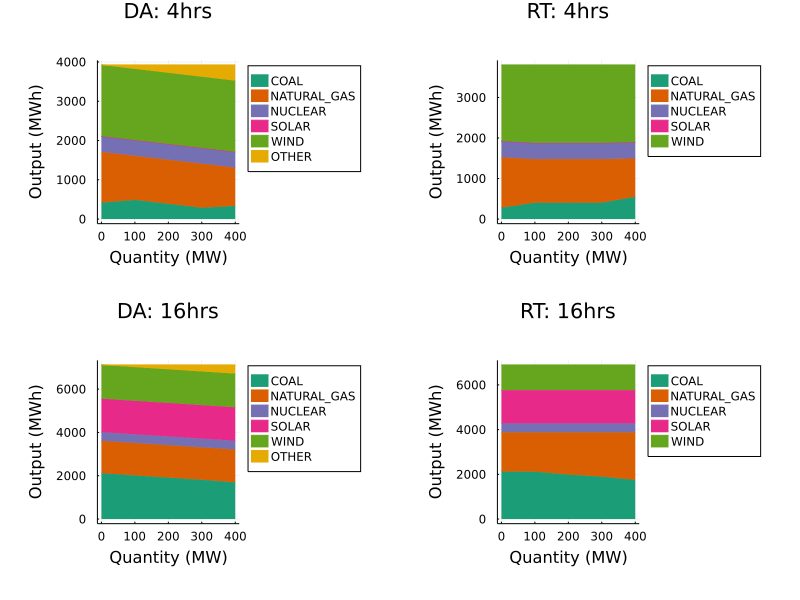

In [37]:
plot(plt_g[2,1,1], plt_g[2,1,2],plt_g[2,2,1], plt_g[2,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 16hrs" "RT: 16hrs"])

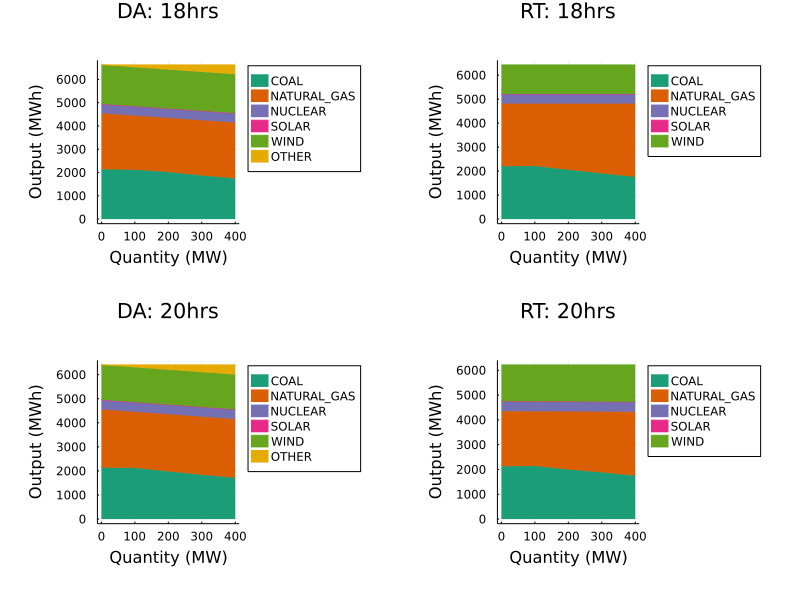

In [41]:
plot(plt_g[2,3,1], plt_g[2,3,2],plt_g[2,4,1], plt_g[2,4,2],layout=4,title=["DA: 18hrs" "RT: 18hrs" "DA: 20hrs" "RT: 20hrs"])

Economic viability

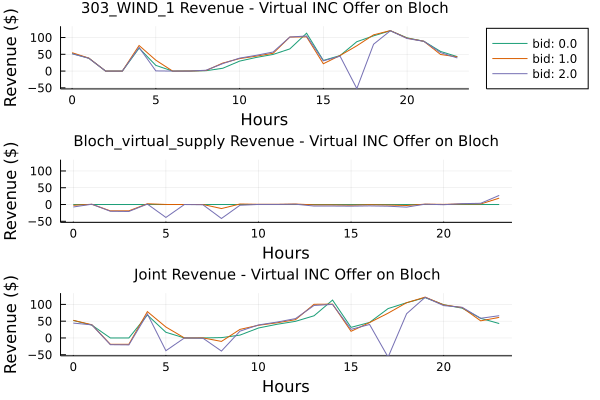

In [39]:
plt_rv[2]

Generation - virtual offer on Chifa

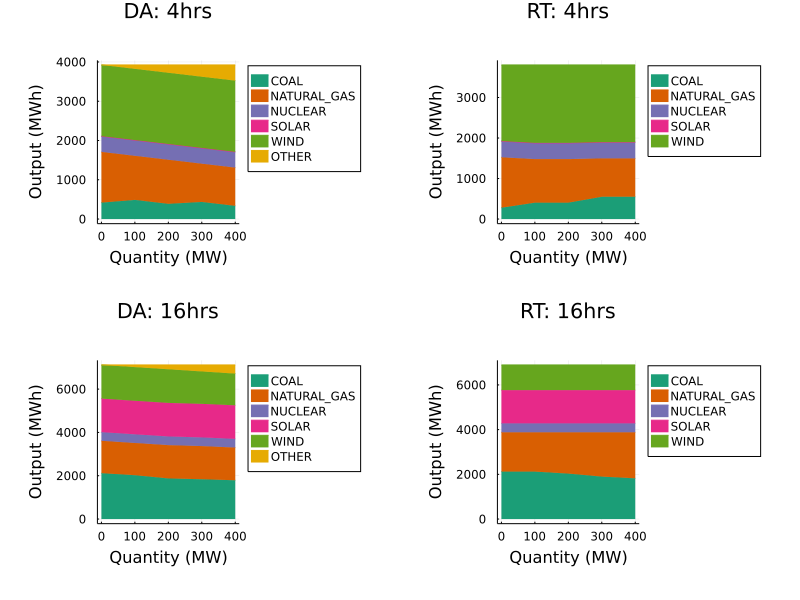

In [40]:
plot(plt_g[3,1,1], plt_g[3,1,2],plt_g[3,2,1], plt_g[3,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 16hrs" "RT: 16hrs"])

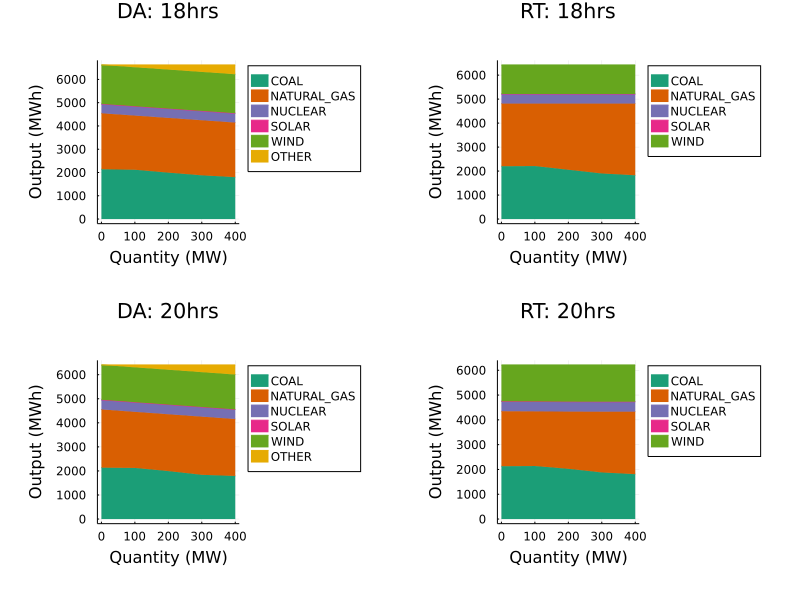

In [42]:
plot(plt_g[3,3,1], plt_g[3,3,2],plt_g[3,4,1], plt_g[3,4,2],layout=4,title=["DA: 18hrs" "RT: 18hrs" "DA: 20hrs" "RT: 20hrs"])

Economic viability

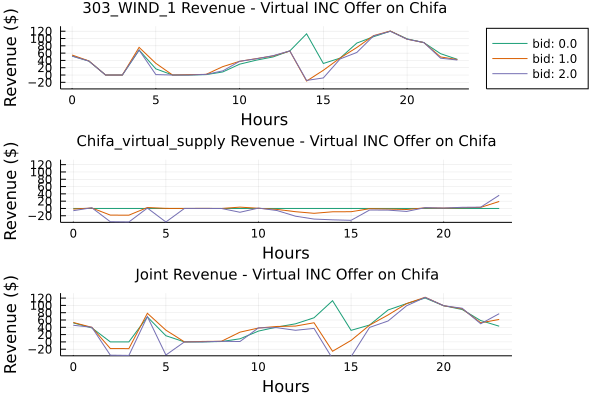

In [43]:
plt_rv[3]

### Balanced and imbalanced bids/offers: Do they have different impacts?

[Fig. up] Coal generation for combinations of virtual sell offers at node 5 (xlabel) and virtual buy offers at node 3 (ylabel) in percentage to coal generation in a context of no virtual offer. On the main diagonal the balanced offers are displayed.

[Fig. down] Coal generation for combinations of virtual sell offers at node 5 (xlabel) and virtual buy offers at node 3 (ylabel) in percentage to coal generation in a context of no virtual offer. Cases with real time usage of fast-starters/energy spillage are set to 2.0.

In [44]:
plt_mix[1]["coal"]

LoadError: UndefVarError: plt_mix not defined

In [ ]:
plt_mix[2]["coal"]

In [ ]:
plt_mix[3]["coal"]

[Fig. up] Set to 1.0 if fast-starters/energy Spillage is needed. Set to 0.0 otherwise.

[Fig. middle] Amount of energy needed from fast-starters.

[Fig. down] Amount of energy  spillage needed.

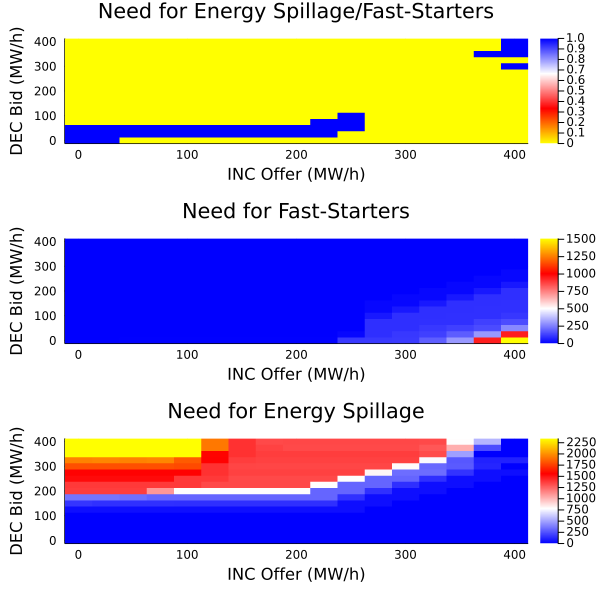

In [28]:
plt_mix[1]["deficit"]

In [ ]:
plt_mix[2]["deficit"]

In [ ]:
plt_mix[3]["deficit"]

Busines model: Revenue from a joint trade into the market. Solar power plant & virtual offer/bid. 

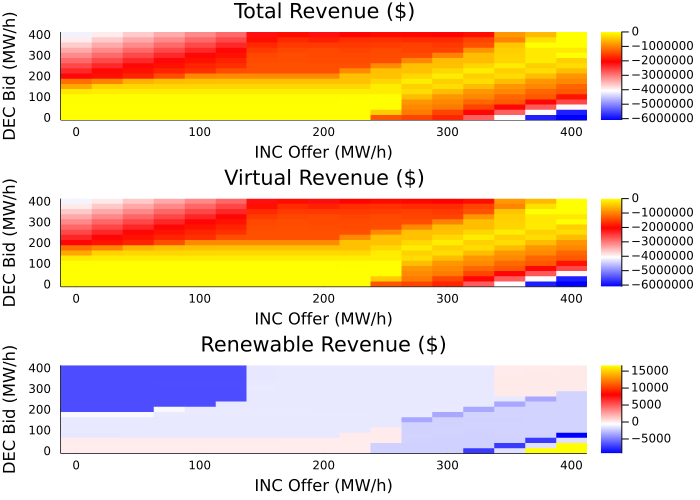

In [30]:
plt_mix[1]["revenue - solar"]

In [ ]:
plt_mix[2]["revenue - solar"]

In [ ]:
plt_mix[3]["revenue - solar"]

Busines model: Revenue from a joint trade into the market. Wind power plant & virtual offer/bid.

The 303_WIND_1 is the wind generator with the higher PMax (MW)

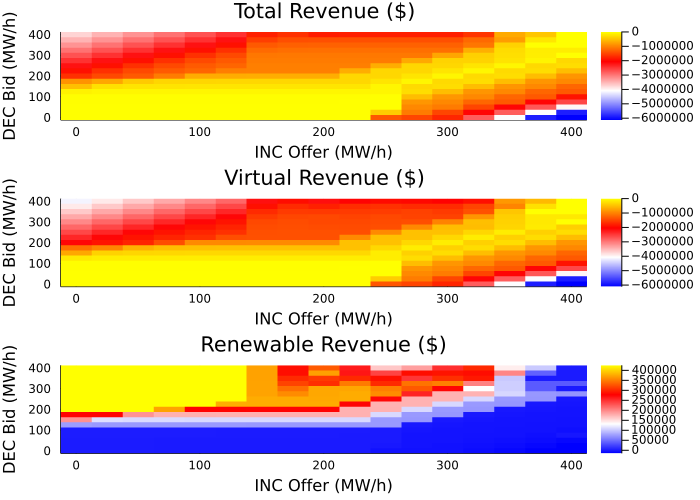

In [34]:
plt_mix[1]["revenue - wind"]

In [ ]:
plt_mix[2]["revenue - wind"]

In [ ]:
plt_mix[3]["revenue - wind"]